# Data Extraction
### code from `data_loader_demo.ipynb`

In [147]:
%load_ext autoreload
%autoreload 2

import warnings

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Exploration
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
import numpy as np
import pandas as pd

import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
import params as p

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, plot_confusion_matrix

from xgboost import XGBClassifier

import optuna
from optuna.integration import XGBoostPruningCallback

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Settings

In [148]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# Financial Phrasebank

In [149]:
# The financial_phrasebank dataset is available in four variations. It has no predefined train/validation/test splits.
# Each data point was annotated by 5-8 people, then their annotations were combined. 
# Each variation of the dataset contains examples with different levels of agreement. 
# Let's use the one containing all data points where at least 50% of the annotators agreed on the label.
dataset = load_dataset(
    "financial_phrasebank", 
    'sentences_50agree' # Select variation of the dataset
)

print(f'The dataset is a dictionary with two splits: \n\n{dataset}')

Reusing dataset financial_phrasebank (/Users/jamesstephenson/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/a6d468761d4e0c8ae215c77367e1092bead39deb08fbf4bffd7c0a6991febbf0)
100%|██████████| 1/1 [00:00<00:00, 47.45it/s]

The dataset is a dictionary with two splits: 

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})


In [150]:
# Split test data from training data
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    dataset["train"]['sentence'], 
    dataset["train"]['label'], 
    test_size=0.2, 
    stratify=dataset["train"]['label']  # make sure the same proportion of labels is in the test set and training set
)

In [151]:
# label 0 = negative, 1 = neutral, 2 = positive
print(f'How many instances in the train dataset? \n\n{len(train_sentences)}')
print('')
print(f'What does one instance look like? \n\n{train_sentences[234]}')

How many instances in the train dataset? 

3876

What does one instance look like? 

The annual value of the contracts is estimated at USD 2mn over the next three years .


It may also be necessary to create a _validation_ set (also called 'development' set or 'devset'). The validation set can be used to compute performance of your model when tuning hyperparameters,  optimising combinations of features, or looking at the errors your model makes before improving it. This allows you to hold out the test set to give a fair evaluation of the model and how well it generalises to new examples. This avoids tuning the model to specifso it gets good performance on the test set examples. 

In [152]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels, test_size=0.25, stratify=train_labels)


In [153]:
print(f'How many instances in the validation dataset? \n\n{len(val_sentences)}\n')
print(f'How many instances in the test dataset? \n\n{len(test_sentences)}')

How many instances in the validation dataset? 

969

How many instances in the test dataset? 

970


# Data Exploration

In [154]:
train = pd.DataFrame({'sentences' : train_sentences, 'labels' : train_labels})

## Very Brief Response Analysis

Should only need to do this for train due to random split. So would expect to see the same structure for test and val

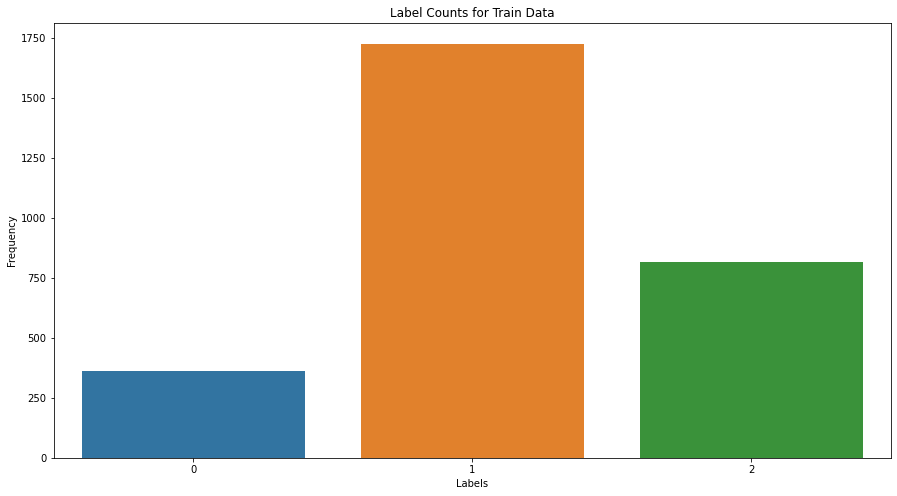

In [155]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 8))

ax = sns.countplot(data = train, x = 'labels').set(title = 'Label Counts for Train Data')

plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.xticks(rotation = 0)

plt.show()

Slight Imbalance of labels, but nothing that will be an issue

# Featuring Engineering

### Sentence Processing

In [156]:
# remove some stopwords to capture negation in n-grams if possible
stop_words = nltk.corpus.stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('but')

# load up a simple porter stemmer
ps = nltk.porter.PorterStemmer()

def simple_text_preprocessor(document): 
    # lower case
    document = str(document).lower()
    
    # remove unnecessary characters
    document = re.sub(r'[^a-zA-Z]',r' ', document)
    
    # simple porter stemming
    document = ' '.join([ps.stem(word) for word in document.split()])
    
    # stopwords removal
    document = ' '.join([word for word in document.split() if word not in stop_words])
    
    return document

stp = np.vectorize(simple_text_preprocessor)

In [157]:
clean_train_sentences = stp(train_sentences)
clean_test_sentences = stp(test_sentences)
clean_val_sentences = stp(val_sentences)

In [158]:
tfidf = TfidfVectorizer(min_df = 0.0, max_df = 1.0, ngram_range = (1, 2))

In [159]:
X_train = tfidf.fit_transform(clean_train_sentences).toarray()
X_train = pd.DataFrame(X_train, columns = tfidf.get_feature_names_out())

X_test = tfidf.transform(clean_test_sentences).toarray()
X_test = pd.DataFrame(X_test, columns = tfidf.get_feature_names_out())

X_val = tfidf.transform(clean_val_sentences).toarray()
X_val = pd.DataFrame(X_val, columns = tfidf.get_feature_names_out())

In [160]:
X_train.head()

,aaland,aaland island,aalborg,aalborg northern,aaron,aaron moss,ab,ab crown,ab decemb,ab lindex,...,zinc stream,zinc use,zloti,zloti mln,zone,zone neudorf,zone sriperumbudur,zone villag,zoo,zoo poland
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling

In [161]:
y_train = train_labels
y_test = test_labels
y_val = val_labels

In [162]:
train_data = {'X' : X_train, 'y' : y_train}
test_data = {'X' : X_test, 'y' : y_test}
val_data = {'X' : X_val, 'y' : y_val}

In [163]:
def evaluate_model(model, X, y):

    y_pred = model.predict(X)
    y_pred_probs = model.predict_proba(X)

    print('ROC AUC Score:\t', roc_auc_score(y, y_pred_probs, average = 'macro', multi_class='ovr'))

    print('--- MACRO ---')
    print(f'Accuracy:\t', accuracy_score(y, y_pred))
    print(f'Precision:\t', precision_score(y, y_pred, average='macro'))
    print(f'Recall:\t\t', recall_score(y, y_pred, average='macro'))
    print(f'F1 score:\t', f1_score(y, y_pred, average='macro'))

    # We can get all of these with a per-class breakdown using classification_report:
    print(classification_report(y, y_pred))

### Naive Bayes

In [164]:
nb = MultinomialNB().fit(**train_data)

In [165]:
evaluate_model(nb, **test_data)

ROC AUC Score:	 0.7904683635062145
--- MACRO ---
Accuracy:	 0.6577319587628866
Precision:	 0.7523964863992388
Recall:		 0.41724142860506497
F1 score:	 0.39266576688910465
              precision    recall  f1-score   support

           0       1.00      0.02      0.03       121
           1       0.67      0.99      0.79       576
           2       0.59      0.25      0.35       273

    accuracy                           0.66       970
   macro avg       0.75      0.42      0.39       970
weighted avg       0.69      0.66      0.57       970



In [166]:
# xgb = XGBClassifier(random_state = p.RANDOM_STATE).fit(**train_data)

In [167]:
# evaluate_model(xgb, **test_data)

In [168]:
# xgb_base_params = {
#     'objective' : 'multi:softprob', 
#     'learning_rate' : 0.1,
#     'verbosity' : 0,
#     'n_jobs' : -1,
#     'random_state' : p.RANDOM_STATE,
#     }

# def xgb_objective(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, base_params = xgb_base_params):

#     obj_params = {
#         'max_depth' : trial.suggest_int('max_depth', 2, 7),
#         'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
#         'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
#         'subsample' : trial.suggest_float('subsample', 0.1, 1),

#         **base_params
#         }

#     pruning_callback = XGBoostPruningCallback(trial, observation_key = 'validation_1-auc')

#     xgb_obj = XGBClassifier(**obj_params)
#     xgb_obj.fit(
#         X_train,
#         y_train,
#         eval_metric = 'auc',
#         eval_set = [(X_train, y_train), (X_test, y_test)],
#         early_stopping_rounds = obj_params['n_estimators'] * 0.1,
#         verbose = 0,
#         callbacks = [pruning_callback]
#         )

#     y_pred = xgb_obj.predict_proba(X_test)

#     roc = roc_auc_score(y_true=y_test, y_score=y_pred, multi_class='ovr')
    
#     return roc

# xgb_study = optuna.create_study(direction = 'maximize')
# xgb_study.optimize(xgb_objective, n_trials = 200, n_jobs = -1)

In [169]:
# xgb_tuned_params = {**xgb_study.best_params, **xgb_base_params}
# xgb_tuned_params


In [170]:
# xgb_tuned = XGBClassifier(**xgb_tuned_params)
# xgb_tuned.fit(
#     **train_data,
#     eval_metric = 'auc',
#     eval_set = [(X_train, y_train), (X_test, y_test)],
#     early_stopping_rounds = xgb_tuned_params['n_estimators'] * 0.1,
#     verbose = 0
#     )


In [171]:
# evaluate_model(xgb_tuned, **test_data)

## NB

In [176]:
def nb_objective(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):

    obj_params = {
        'alpha' : trial.suggest_uniform('alpha', 0.2, 2),
        'fit_prior' : trial.suggest_categorical('fit_prior', [True, False])
    }

    nb_obj = MultinomialNB(**obj_params)
    nb_obj.fit(X_train, y_train)

    y_pred = nb_obj.predict_proba(X_test)

    roc = roc_auc_score(y_true = y_test, y_score = y_pred, average = 'macro', multi_class='ovr')
    
    return roc

nb_study = optuna.create_study(direction='maximize')
nb_study.optimize(nb_objective, n_trials = 200, n_jobs = -1)

[I 2022-03-26 12:10:31,144] A new study created in memory with name: no-name-786dd108-dac1-458e-859d-57f2c59fbd83
[I 2022-03-26 12:10:33,191] Trial 1 finished with value: 0.7849826240790184 and parameters: {'alpha': 1.9180133999876379, 'fit_prior': False}. Best is trial 1 with value: 0.7849826240790184.
[I 2022-03-26 12:10:33,207] Trial 2 finished with value: 0.7953083423961856 and parameters: {'alpha': 0.7733854125749329, 'fit_prior': True}. Best is trial 2 with value: 0.7953083423961856.
[I 2022-03-26 12:10:33,302] Trial 4 finished with value: 0.7915627906204389 and parameters: {'alpha': 1.4210610476895136, 'fit_prior': False}. Best is trial 2 with value: 0.7953083423961856.
[I 2022-03-26 12:10:34,956] Trial 3 finished with value: 0.7921263022396765 and parameters: {'alpha': 1.3834066407440966, 'fit_prior': False}. Best is trial 2 with value: 0.7953083423961856.
[I 2022-03-26 12:10:34,987] Trial 0 finished with value: 0.7945160703821644 and parameters: {'alpha': 0.8055931842856754, '

In [23]:
nb_tuned_params = nb_study.best_params.copy()

In [24]:
nb_tuned = MultinomialNB(**nb_tuned_params).fit(**train_data)

In [25]:
evaluate_model(nb_tuned, **test_data)

ROC AUC Score:	 0.8400634937370027
--- MACRO ---
Accuracy:	 0.7134020618556701
Precision:	 0.6582304164815089
Recall:		 0.6116433545410818
F1 score:	 0.6293978414038203
              precision    recall  f1-score   support

           0       0.59      0.42      0.49       121
           1       0.77      0.84      0.81       576
           2       0.61      0.57      0.59       273

    accuracy                           0.71       970
   macro avg       0.66      0.61      0.63       970
weighted avg       0.70      0.71      0.71       970



### Post-tuned Performance

In [26]:
evaluate_model(nb, **val_data)

ROC AUC Score:	 0.7960796704420791
--- MACRO ---
Accuracy:	 0.6780185758513931
Precision:	 0.7838902839482326
Recall:		 0.4562995710221646
F1 score:	 0.45830992391549846
              precision    recall  f1-score   support

           0       1.00      0.08      0.15       121
           1       0.67      0.98      0.80       576
           2       0.68      0.31      0.42       272

    accuracy                           0.68       969
   macro avg       0.78      0.46      0.46       969
weighted avg       0.72      0.68      0.61       969



### Confusion Matrix

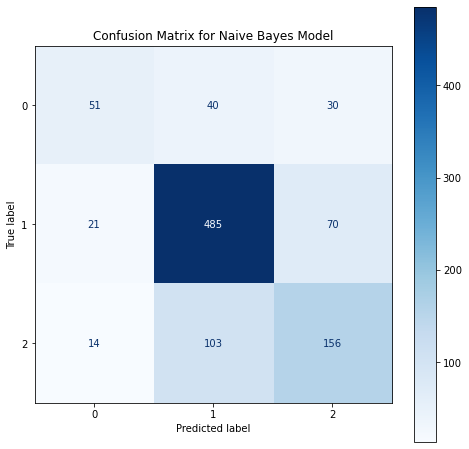

In [68]:
def create_confusion_matrix(model, model_name):
    fig, ax = plt.subplots(1, 1, figsize = (8,8))
    plot_confusion_matrix(model, X_test, y_test, cmap = 'Blues', ax = ax)
    plt.title(f'Confusion Matrix for {model_name} Model')
    plt.show()

create_confusion_matrix(nb_tuned, 'Naive Bayes')

### Feature Importance

In [ ]:
fi = pd.DataFrame(nb_tuned.coef_, columns = X_val.columns).T

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 8))

for idx, col in enumerate(fi.columns):
    fi_sort = fi.sort_values(col, ascending = False).head(10)
    sns.barplot(ax = ax[idx], data = fi, x = col, y = fi.index)
plt.show()